In [37]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from sotodlib import core
import sotodlib.io.load as io_load

from moby2.analysis import socompat
socompat.register_loaders()

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [38]:
### This is used for .g3 files that are not part of an observation database
#fname = '/mnt/so1/shared/todsims/pipe-s0001/v4/datadump_LAT_MFF1/CES-Atacama-LAT-Tier1DEC-035..-045_RA+040..+050-0-0/MFF1_wafer_13_00000000.g3'
fname = '/global/project/projectdirs/sobs/todsims/pipe-s0001/v4/datadump_LAT_MFF1/CES-Atacama-LAT-Tier1DEC-035..-045_RA+040..+050-0-0/MFF1_wafer_13_00000000.g3'
tod = io_load.load_file(fname)

In [39]:
%%writefile simons1_pipe_s0001_v4.yaml
tags:
    sim_base_dir: '/mnt/so1/shared/todsims/pipe-s0001/v4'
    meta_dir:     '/mnt/so1/shared/todsims/pipe-s0001/v4'

obsfiledb:  '{meta_dir}/obsfiledb.sqlite'
detdb:      '{meta_dir}/detdb_lat.gz'
obsdb:      '{meta_dir}/obsdb.gz'

obs_colon_tags: ['band', 'wafer', 'fcode']
obs_loader_type: 'pipe-s0001'

metadata:
  - db: '{meta_dir}/focalplane.gz'
    name: "focal_plane"

Overwriting simons1_pipe_s0001_v4.yaml


In [40]:
nersc_todsims = '/global/project/projectdirs/sobs/todsims/pipe-s0001/v4/context.yaml'
nersc_actpol = '/global/project/projectdirs/sobs/users/mhasse/actpol_demo/uranus_200327/metadata/context.yaml'

In [41]:
context = core.Context(nersc_todsims)
#context = core.Context('simons1_pipe_act_uranus.yaml')

In [42]:
# what is the .yaml look like?
import yaml
with open(nersc_todsims) as file:
    text = yaml.load(file, Loader=yaml.FullLoader)
    for item, doc in text.items():
        print(item, ":", doc)

tags : {'sim_base_dir': '/global/project/projectdirs/sobs/todsims/pipe-s0001/v4', 'meta_dir': '/global/project/projectdirs/sobs/todsims/pipe-s0001/v4'}
obsfiledb : {meta_dir}/obsfiledb.sqlite
detdb : {meta_dir}/detdb_lat.gz
obsdb : {meta_dir}/obsdb.gz
obs_colon_tags : ['band', 'wafer', 'fcode']
obs_loader_type : pipe-s0001
metadata : [{'db': '{meta_dir}/focalplane.gz', 'name': 'focal_plane'}]


In [43]:
## This returns a ResultSet that lists all the observations in the observation database
obs_list = context.obsdb.get()

print("There are {} observations currently in the database".format(len(obs_list)))

## Choose a random observation from the database
# x = np.random.randint(len(obs_list))
x = 138
my_obs = obs_list[x]

## We might want to know things able the observation we are looking at
print("Observation: {}".format(my_obs['obs_id']))
for k in my_obs:
    if k == 'obs_id':
        continue
    print('\t', k,':', my_obs[k])

There are 380 observations currently in the database
Observation: CES-Atacama-LAT-Tier1DEC-035..-045_RA+040..+050-21-0_MFF
	 timestamp : 1626614093.009091
	 drift : setting
	 az_min : -141.84857751648792
	 az_max : -128.821422483511
	 az_med : -135.4197826219584
	 el_min : 57.23000345371954
	 el_max : 60.22999654516515
	 el_med : 58.73
	 is_const_el : 0
	 is_const_az : 0
	 is_stare : 0


In [44]:
## Detector Sets are how the observation files are saved at the moment. 
det_sets = context.obsfiledb.get_detsets( my_obs['obs_id'] )
print('The different detector sets are: \n', det_sets)

dets = context.obsfiledb.get_dets(det_sets[0])
print('\nThe first 10 detectors of the first detector set are:\n',dets[:10])

### Just create a tod with n detectors
detector_nums = 1
tod = context.get_obs(my_obs, dets=dets[:detector_nums])

The different detector sets are: 
 ['MFF1_wafer_13', 'MFF1_wafer_14', 'MFF1_wafer_15', 'MFF1_wafer_16', 'MFF1_wafer_17', 'MFF1_wafer_18', 'MFF2_wafer_13', 'MFF2_wafer_14', 'MFF2_wafer_15', 'MFF2_wafer_16', 'MFF2_wafer_17', 'MFF2_wafer_18']

The first 10 detectors of the first detector set are:
 ['13_000_MFF1_A', '13_000_MFF1_B', '13_001_MFF1_A', '13_001_MFF1_B', '13_002_MFF1_A', '13_002_MFF1_B', '13_003_MFF1_A', '13_003_MFF1_B', '13_004_MFF1_A', '13_004_MFF1_B']


In [45]:
print('tod type: {}'.format(type(tod)))
print('tod.timestamps: {}'.format(type(tod.timestamps)))
print('tod.boresight: {}'.format(type(tod.boresight)))
print('tod.flags: {}\n'.format(type(tod.flags)))
print(tod)

tod type: <class 'sotodlib.core.axisman.AxisManager'>
tod.timestamps: <class 'numpy.ndarray'>
tod.boresight: <class 'sotodlib.core.axisman.AxisManager'>
tod.flags: <class 'sotodlib.core.flagman.FlagManager'>

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], dets:LabelAxis(1), samps:OffsetAxis(214278))


In [46]:
sig_mean = np.mean( tod.signal, axis = 0)
tod.wrap('sig_mean', sig_mean, [(0,tod.samps)])

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], dets:LabelAxis(1), samps:OffsetAxis(214278))

In [47]:
tsamp = np.median(np.diff(tod.timestamps))
n_cut = int(10//tsamp)
print('Trimming in time...')

tod.restrict('samps', (n_cut, tod.samps.count-n_cut))
print('The TOD now has {} samples'.format(tod.samps.count))

Trimming in time...


AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], dets:LabelAxis(1), samps:OffsetAxis(209878))

The TOD now has 209878 samples


Text(0.5, 0, 'Time (s)')

Text(0, 0.5, 'Signal (K)')

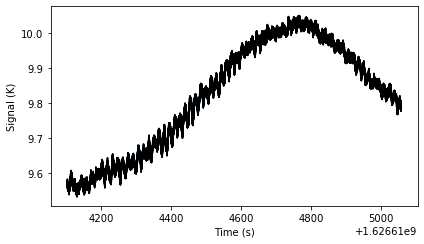

In [48]:
fig = plt.figure(figsize=(6,3.5))
for i in range(tod.dets.count):
    plt.plot(tod.timestamps, tod.signal[i])
if hasattr(tod, 'sig_mean'):
    plt.plot(tod.timestamps, tod.sig_mean, 'k-')
plt.xlabel('Time (s)')
plt.ylabel('Signal (K)')
fig.tight_layout()

In [49]:
# tod is an AxisManager, it's like a list, each element in the list is a ndarray with a name
# try "tod"
# tod = context.get_obs(my_obs, dets=dets[:detector_nums])
?context.get_obs
print(type(tod))
tod

Signature: context.get_obs(obs_id=None, dets=None, detsets=None, loader_type=None)
Docstring:
Load TOD and supporting metadata for a particular observation id.
The detectors to read can be specified through colon-coding in
obs_id, through dets, or through detsets.

After figuring out what detectors you want, loader_type will
be used to fund a loader function in the OBSLOADER_REGISTRY.
File:      /global/common/software/sobs/cori/gnu_20200623/lib/python3.7/site-packages/sotodlib-0+unknown-py3.7.egg/sotodlib/core/context.py
Type:      method


<class 'sotodlib.core.axisman.AxisManager'>


AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], dets:LabelAxis(1), samps:OffsetAxis(209878))

In [50]:
from sotodlib.core import FlagManager

import sotodlib.flags as flags
import sotodlib.sim_flags as sim_flags

import sotodlib.tod_ops.filters as filters

from sotodlib.tod_ops import fourier_filter, rfft, detrend_data

In [79]:
if 1:
    if 'badness' in tod:
        tod.move('badness', None)

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], bad_signal[dets,samps], dets:LabelAxis(1), samps:OffsetAxis(209878))

Text(0.5, 0, 'Time (s)')

Text(0, 0.5, 'Signal (K)')

sotodlib.core.axisman.AxisManager

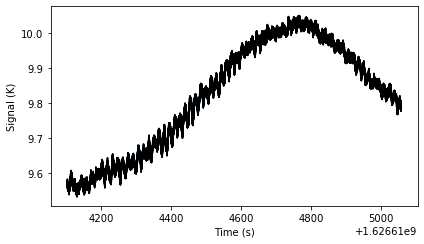

In [80]:
fig = plt.figure(figsize=(6,3.5))
for i in range(tod.dets.count):
    if not 'badness' in tod:
        plt.plot(tod.timestamps, tod.signal[i])
    else:
        plt.plot(tod.timestamps, tod.signal[i]+tod.badness[i])
if hasattr(tod, 'sig_mean'):
    plt.plot(tod.timestamps, tod.sig_mean, 'k-')
plt.xlabel('Time (s)')
plt.ylabel('Signal (K)')
fig.tight_layout()

# remember tod is an AxisManager object(class)
type(tod)

In [95]:
# add a glitch with a height
sim_flags.add_random_glitches(tod, params={'n_glitch':2, 'sig_n_glitch' : 0,'h_glitch':8}, signal='badness', overwrite='True')

In [96]:
def in_range(Points, Ranges):
    results = np.zeros_like(Ranges)
    for j, Point in enumerate(Points):
        for i, Range in enumerate(Ranges[j:]):
            if Point in Range:
                results[i+j] = 1
            else:
                results[i+j] = 0
    return results

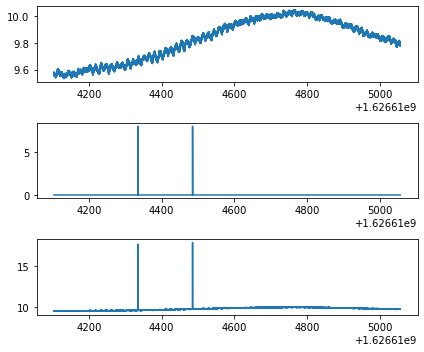

In [97]:
fig = plt.figure(figsize=(6,5))

plt.subplot(3,1,1)
plt.plot(tod.timestamps, tod.signal[0])

plt.subplot(3,1,2)
plt.plot(tod.timestamps, tod.badness[0])

plt.subplot(3,1,3)
plt.plot(tod.timestamps, tod.signal[0] + tod.badness[0])

fig.tight_layout()

In [98]:
## if bad signal is already there, remove it
signal_name = 'bad_signal'
if signal_name in tod:
    tod.move(signal_name, None)
## add the bad signal to the tod
tod.wrap(signal_name, tod.signal+tod.badness, [(0, tod.dets), (1, tod.samps)])

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], badness[dets,samps], dets:LabelAxis(1), samps:OffsetAxis(209878))

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], badness[dets,samps], bad_signal[dets,samps], dets:LabelAxis(1), samps:OffsetAxis(209878))

In [99]:
found_glitches = flags.get_glitch_flags(tod, signal='bad_signal', overwrite=True)
found_glitches.ranges[0].ranges()[1:-1]

array([[50508, 51196],
       [83675, 84388]], dtype=int32)

In [100]:
tod

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], badness[dets,samps], bad_signal[dets,samps], dets:LabelAxis(1), samps:OffsetAxis(209878))

In [101]:
# how to get true glitches' positions in a tod?
print(type(tod.flags.true_glitches))
print(type(tod.flags.true_glitches[0].ranges()))
tod.flags.true_glitches[0].ranges()

<class 'so3g.proj.ranges.RangesMatrix'>
<class 'numpy.ndarray'>


array([[50872, 50873],
       [84021, 84022]], dtype=int32)

In [60]:
true_glitch_array = tod.flags.true_glitches[0].ranges()
true_glitch_positions = [i[0] for i in true_glitch_array]
true_glitch_positions
found_glitches_ranges = tod.flags.true_glitches[0].ranges()
if true_glitch_positions[0] in found_glitches_ranges[0]:
    print('yes')
type(tod.flags.true_glitches[0].ranges())
tod.flags.true_glitches[0].ranges()[:, 0].size

[93818, 182525]

yes


numpy.ndarray

2

In [61]:
def in_range(Points,  Ranges):
    results = np.zeros_like(Ranges[:, 0].size)
    for Point in Points:
        for i, Range in enumerate(Ranges):
            if Point in Range:
                results[i] = 1
            else:
                results[i] = 0
                break
        return results
                

In [63]:
Points = np.array([1, 3, 6])
Ranges = np.array([[0,2], [2,4], [4,6]])


In [64]:
x = np.arange(10)
type(x)

numpy.ndarray

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], badness[dets,samps], bad_signal[dets,samps], dets:LabelAxis(1), samps:OffsetAxis(209878))

array([[9.57282925, 9.56878757, 9.57181263, ..., 9.77979565, 9.78743935,
        9.77903843]])

2

array([9.58129692, 9.58217907, 9.5796299 , 9.58625412, 9.58230591])

<Figure size 720x216 with 0 Axes>

Text(0.5, 1.0, 'glitch 1')

Text(0.5, 1.0, 'glitch 2')

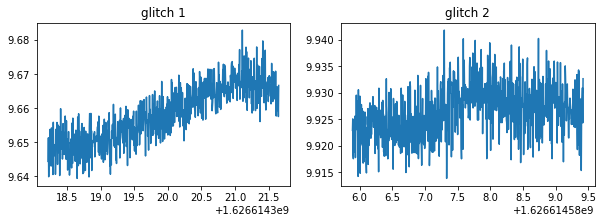

In [65]:
# let's hava a look at what a glitch look like
tod
tod.bad_signal
tod.bad_signal.ndim
tod.bad_signal[0,3090:3095]
plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.plot(tod.timestamps[47346:48102], tod.bad_signal[0,  47346:48102])
plt.title('glitch 1')

plt.subplot(1,2,2)
plt.plot(tod.timestamps[106234:107011], tod.bad_signal[0, 106234:107011])
plt.title('glitch 2')

In [66]:
# how to identify that we find a glitch successfully?
# visualize true positive and false positve
found_glitches.ranges[0].ranges()
found_glitches.ranges[0].ranges()[1:-1]

array([[     0,    209],
       [ 93474,  94162],
       [182205, 182890],
       [209668, 209878]], dtype=int32)

array([[ 93474,  94162],
       [182205, 182890]], dtype=int32)

In [67]:
n_t_glitch = np.sum([len(t.ranges()) for t in tod.flags.true_glitches])
print(n_t_glitch)

2


In [68]:
print(found_glitches.ranges[0].ranges())
print(found_glitches.ranges)
print(found_glitches.ranges[0])

[[     0    209]
 [ 93474  94162]
 [182205 182890]
 [209668 209878]]
Ranges(n=209878:rngs=4)


In [69]:
found_glitches.get_stats()

{'samples': [1792], 'intervals': [4]}

In [70]:
# how many true glitches in tod?
n_t_glitch = np.sum([len(t.ranges()) for t in tod.flags.true_glitches])
print(n_t_glitch)

2


In [71]:
tod.flags.true_glitches

RangesMatrix(1,209878)

In [72]:
if 'bad_signal' in tod:
    tod.move('bad_signal', None)

AxisManager(signal[dets,samps], timestamps[samps], boresight*[samps], qboresight_azel[samps,4], qboresight_radec[samps,4], site*[samps], flags*[dets,samps], focal_plane*[dets], sig_mean[samps], badness[dets,samps], dets:LabelAxis(1), samps:OffsetAxis(209878))

Text(0.5, 0, 'Time (s)')

Text(0, 0.5, 'Signal (K)')

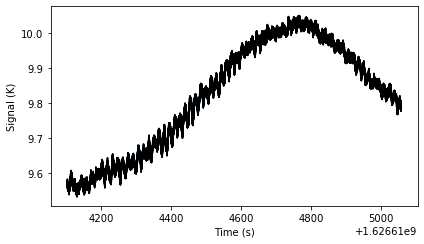

In [73]:
fig = plt.figure(figsize=(6,3.5))
for i in range(tod.dets.count):
    plt.plot(tod.timestamps, tod.signal[i])
if hasattr(tod, 'sig_mean'):
    plt.plot(tod.timestamps, tod.sig_mean, 'k-')
plt.xlabel('Time (s)')
plt.ylabel('Signal (K)')
fig.tight_layout()

In [ ]:
flags.get_glitch_flags
tod.signal.size

In [ ]:
height = 10

def true_positive(tod, height=None, num=None, signal=None):
    if 'badness' in tod:
        tod.move('badness', None)

    for i in range(num):
        sim_flags.add_random_glitches(tod, params={'h_glitch':height}, signal='badness')

    if signal in tod:
        tod.move(signal, None)
    ## add the bad signal to the tod
    tod.wrap(signal, tod.signal+tod.badness, [(0, tod.dets), (1, tod.samps)])
    
    # flags.get_glitch_flags uses fourier filtering translation from moby2 at starting point
    found_glitches = flags.get_glitch_flags(tod, signal=signal, overwrite=True)
    
    return found_glitches

In [ ]:
found_glitches = true_positive(tod, height=10, num=5, signal='bad_signal')